# Лабораторная работа 2

Проверка GPU:

In [1]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 129355985603096277
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3412000768
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10498004134139785763
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Задание 1

Импорт библиотек

In [2]:
import keras
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Инициализация генератора

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    './natural-scenes/seg_train/seg_train',
    target_size=(150, 150), # размер итоговых изображений
    color_mode='rgb', # (альтернатива greyscale)
    batch_size=32, # генерируется за один проход
    class_mode='categorical', # режим множественной классификации
    shuffle=True
)

Found 14034 images belonging to 6 classes.


In [4]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(
    './natural-scenes/seg_test/seg_test',
    target_size=(150, 150), # размер итоговых изображений
    color_mode='rgb', # (альтернатива greyscale)
    batch_size=32, # генерируется за один проход
    class_mode='categorical', # режим множественной классификации
    shuffle=True
)

Found 3000 images belonging to 6 classes.


In [5]:
NUM_OF_CLASSES = 6

### 1.3

> Добавить dropout

In [48]:
from keras.layers import Dense,GlobalAveragePooling2D 
from keras.layers.core import Activation
from keras.models import Model

base_model = MobileNet(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

output_model = base_model.output
output_model = GlobalAveragePooling2D()(output_model)
output_model = Dense(1024, activation='relu')(output_model)
output_model = Dense(512, activation='relu')(output_model)
output_model = Dense(NUM_OF_CLASSES, activation='softmax')(output_model)

model = Model(inputs=base_model.input, outputs=output_model)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 75, 75, 32)        0   

Отключаем обучение базовой модели **MobileNet**

In [49]:
for layer in base_model.layers:
    layer.trainable = False

In [50]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 75, 75, 32)        0   

Компилируем

In [51]:
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Обучаем добавленные кастомные слои

In [52]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size
history = model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=valid_generator,
    validation_steps=step_size_valid,
    epochs=10
)

Epoch 1/10
438/438 [==============================] - 27s 59ms/step - loss: 0.4368 - accuracy: 0.8458 - val_loss: 0.2694 - val_accuracy: 0.8894
Epoch 2/10
438/438 [==============================] - 26s 58ms/step - loss: 0.2046 - accuracy: 0.9276 - val_loss: 0.2445 - val_accuracy: 0.9167
Epoch 3/10
438/438 [==============================] - 26s 59ms/step - loss: 0.1614 - accuracy: 0.9391 - val_loss: 0.2031 - val_accuracy: 0.9308
Epoch 4/10
438/438 [==============================] - 26s 60ms/step - loss: 0.1451 - accuracy: 0.9456 - val_loss: 0.2155 - val_accuracy: 0.9267
Epoch 5/10
438/438 [==============================] - 26s 59ms/step - loss: 0.1146 - accuracy: 0.9560 - val_loss: 0.2326 - val_accuracy: 0.9224
Epoch 6/10
438/438 [==============================] - 26s 58ms/step - loss: 0.1009 - accuracy: 0.9605 - val_loss: 0.2548 - val_accuracy: 0.9251
Epoch 7/10
438/438 [==============================] - 25s 58ms/step - loss: 0.0685 - accuracy: 0.9748 - val_loss: 0.2693 - val_accuracy:

Сохраняем модель

In [54]:
model.save('nature_scenes_conv_model.h5')
model.save_weights('nature_scenes_conv_model_weights.h5')

Выводим статистику по обучению и точности распознавания на тестовой выборке

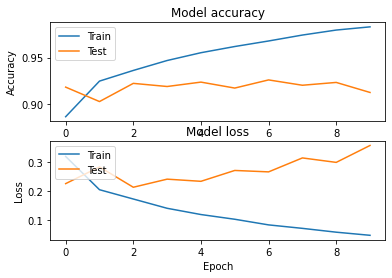

In [12]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [53]:
_, accuracy = model.evaluate(valid_generator)
accuracy

94/94 [==============================] - 5s 48ms/step - loss: 0.3246 - accuracy: 0.9197


0.9196666479110718

### 1.4

In [19]:
import tensorflow as tf

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
    for k, initializer in layer.__dict__.items():
        if "initializer" not in k:
            continue
        # find the corresponding variable
        var = getattr(layer, k.replace("_initializer", ""))
        var.assign(initializer(var.shape, var.dtype))
        
reset_weights(model)

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=valid_generator,
    validation_steps=step_size_valid,
    epochs=10
)

Epoch 1/10
438/438 [==============================] - 127s 286ms/step - loss: 0.5730 - accuracy: 0.8118 - val_loss: 0.5260 - val_accuracy: 0.8431
Epoch 2/10
438/438 [==============================] - 124s 284ms/step - loss: 0.2948 - accuracy: 0.9052 - val_loss: 0.3016 - val_accuracy: 0.8915
Epoch 3/10
438/438 [==============================] - 125s 285ms/step - loss: 0.2323 - accuracy: 0.9242 - val_loss: 0.2973 - val_accuracy: 0.8942
Epoch 4/10
438/438 [==============================] - 125s 286ms/step - loss: 0.2040 - accuracy: 0.9311 - val_loss: 0.3446 - val_accuracy: 0.8760
Epoch 5/10
438/438 [==============================] - 126s 287ms/step - loss: 0.1897 - accuracy: 0.9379 - val_loss: 0.3208 - val_accuracy: 0.8952
Epoch 6/10
438/438 [==============================] - 125s 286ms/step - loss: 0.1600 - accuracy: 0.9477 - val_loss: 0.3422 - val_accuracy: 0.8871
Epoch 7/10
438/438 [==============================] - 126s 287ms/step - loss: 0.1577 - accuracy: 0.9475 - val_loss: 0.3325 -

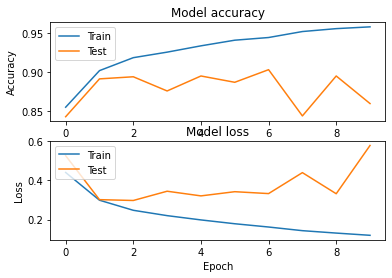

In [21]:
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [22]:
_, accuracy = model.evaluate(valid_generator)
accuracy

94/94 [==============================] - 5s 47ms/step - loss: 0.5788 - accuracy: 0.8593


0.859333336353302

### 1.5

In [55]:
model = keras.models.load_model('nature_scenes_conv_model.h5')
model.load_weights('nature_scenes_conv_model_weights.h5')

In [56]:
for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 75, 75, 32)        0   

In [57]:
history = model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=valid_generator,
    validation_steps=step_size_valid,
    epochs=3
)

Epoch 1/3
438/438 [==============================] - 132s 297ms/step - loss: 0.6067 - accuracy: 0.8434 - val_loss: 0.4476 - val_accuracy: 0.8690
Epoch 2/3
438/438 [==============================] - 132s 302ms/step - loss: 0.2725 - accuracy: 0.9106 - val_loss: 0.2793 - val_accuracy: 0.9012
Epoch 3/3
438/438 [==============================] - 131s 298ms/step - loss: 0.2260 - accuracy: 0.9242 - val_loss: 0.4477 - val_accuracy: 0.8323


In [58]:
_, accuracy = model.evaluate(valid_generator)
accuracy

94/94 [==============================] - 5s 48ms/step - loss: 0.4456 - accuracy: 0.8330


0.8330000042915344

# 2

In [1]:
from __future__ import absolute_import
from __future__ import division
import keras
from keras.datasets import mnist
import numpy as np
# Считываем данные из MNIST
(x_train, _), (x_test, _) = mnist.load_data()
# Нормируем данные и приводим массивы к виду (N,size1,size1,1)
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [2]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
# Ограничим итоговые значения интервалом [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [61]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Зададим два сверточных слоя и число нейронов в каждом слое:
layer_filters = [32, 64]

In [73]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K

encoder_inputs = Input(shape=input_shape, name='encoder_input')
x = encoder_inputs
# Стек из сверточных слоев (strides - дискрет сдвига окна свертки
# в пикселях, padding - без заполнения нулями):
for filters in layer_filters:
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=2,
        activation='relu',
        padding='same'
    )(x)
    
# Запоминаем размерность выхода для построения модели декодера
shape = K.int_shape(x)

# Преобразуем многомерный массив в вектор
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# Итоговый код - одномерный вектор меньшей размерности (latent_dim)

# Итоговая модель энкодера:
encoder = Model(encoder_inputs , latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [63]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# Обратное преобразование к размеру "shape":
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# Выход должен быть трехмерным массивом:
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [64]:
# Вместо сверточных слоев "разверточные", цикл в обратном порядке:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=2,
        activation='relu',
        padding='same'
    )(x)
    
x = Conv2DTranspose(
    filters=1,
    kernel_size=kernel_size,
    padding='same'
)(x)

outputs = Activation('sigmoid', name='decoder_output')(x)
# Итоговая модель декодера:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

In [65]:
autoencoder = Model(
    encoder_inputs,
    decoder(encoder(encoder_inputs)),
    name='autoencoder'
)
autoencoder.compile(loss='mse', optimizer='adam')

In [66]:
# Запускаем модель на обучение, используя незашумленные данные как эталонные.
history = autoencoder.fit(
    x_train_noisy,
    x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=30,
    batch_size=batch_size
)

Epoch 1/30
469/469 [==============================] - 6s 11ms/step - loss: 0.0839 - val_loss: 0.0378
Epoch 2/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0319 - val_loss: 0.0239
Epoch 3/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0234 - val_loss: 0.0207
Epoch 4/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0204 - val_loss: 0.0190
Epoch 5/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0188 - val_loss: 0.0182
Epoch 6/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 7/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 8/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 9/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0168 - val_loss: 0.0169
Epoch 10/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0164 - val_lo

In [67]:
autoencoder.save('autoencoder.h5')
autoencoder.save_weights('autoencoder_weights.h5')

In [68]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

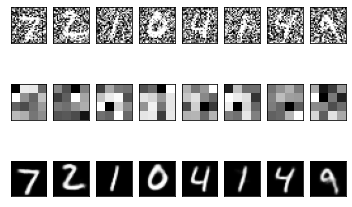

In [72]:
import matplotlib.pyplot as plt

n = 8  # How many digits we will display

for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display encoded
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Display decoded
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### 2.3

In [27]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64, 128]

In [29]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K

encoder_inputs = Input(shape=input_shape, name='encoder_input')
x = encoder_inputs

for filters in layer_filters[:-1]:
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=2,
        activation='relu',
        padding='same'
    )(x)
    
x = Conv2D(
    filters=128,
    kernel_size=kernel_size,
    strides=1,
    activation='relu',
    padding='same'
)(x)
    
# Запоминаем размерность выхода для построения модели декодера
shape = K.int_shape(x)

# Преобразуем многомерный массив в вектор
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# Итоговый код - одномерный вектор меньшей размерности (latent_dim)

# Итоговая модель энкодера:
encoder = Model(encoder_inputs , latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                100368    
Total params: 193,040
Trainable params: 193,040
Non-trainable params: 0
_____________________________________________________

In [30]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# Обратное преобразование к размеру "shape":
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# Выход должен быть трехмерным массивом:
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [31]:
x = Conv2DTranspose(
    filters=128,
    kernel_size=kernel_size,
    strides=1,
    activation='relu',
    padding='same'
)(x)

for filters in layer_filters[::-1][1:]:
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=2,
        activation='relu',
        padding='same'
    )(x)
    
x = Conv2DTranspose(
    filters=1,
    kernel_size=kernel_size,
    padding='same'
)(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              106624    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 7, 7, 128)         147584    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289 

In [32]:
autoencoder = Model(
    encoder_inputs,
    decoder(encoder(encoder_inputs)),
    name='autoencoder'
)
autoencoder.compile(loss='mse', optimizer='adam')

In [33]:
history = autoencoder.fit(
    x_train_noisy,
    x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=30,
    batch_size=batch_size
)

Epoch 1/30
469/469 [==============================] - 11s 16ms/step - loss: 0.0784 - val_loss: 0.0256
Epoch 2/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0228 - val_loss: 0.0181
Epoch 3/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0178 - val_loss: 0.0166
Epoch 4/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 5/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0155 - val_loss: 0.0156
Epoch 6/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 7/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0144 - val_loss: 0.0149
Epoch 8/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0140 - val_loss: 0.0152
Epoch 9/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0138 - val_loss: 0.0151
Epoch 10/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0134 - val_l

In [35]:
autoencoder.save('autoencoder_alt.h5')
autoencoder.save_weights('autoencoder_weights_alt.h5')

In [36]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

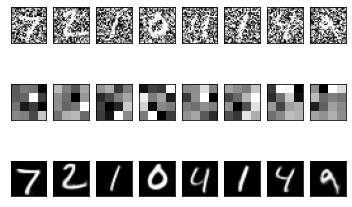

In [39]:
import matplotlib.pyplot as plt

n = 8  # How many digits we will display

for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display encoded
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Display decoded
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()